In [1]:
import os
from pathlib import Path
os.chdir("/Users/mregan/Dev/Litmus-freqtrade-temp/")
print(Path.cwd())

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

/Users/mregan/Dev/Litmus-freqtrade-temp


In [2]:
import pandas as pd
import numpy as np
from user_data.litmus import get_labeled_data
from user_data.litmus import meta_model

pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

In [3]:
ld = get_labeled_data.GetLabeledData(
    timeframe='12h',
    latest=False,
    bt_filename='backtest_vulcanprimary-2022-05-01_11-51-51.json',
    bt_pkl_filename='backtest_vulcanprimary-2022-05-01_11-51-51_signals.pkl')

In [4]:
df = ld.get_all_data()
df

open    high     low  \
strategy      pair       date                                                
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  3.9949  4.4662  3.9887   
                         2021-03-17 00:00:00+00:00  4.5603  4.8100  4.2512   
                         2021-04-04 12:00:00+00:00  4.3702  4.7020  4.3340   
                         2021-04-13 12:00:00+00:00  5.4557  5.7313  5.4438   
                         2021-04-30 12:00:00+00:00  5.5725  5.6900  5.5086   
...                                                    ...     ...     ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8718  0.8989  0.8416   
                         2022-01-01 12:00:00+00:00  0.8298  0.8759  0.8296   
                         2022-02-03 00:00:00+00:00  0.5715  0.5953  0.5686   
                         2022-02-16 00:00:00+00:00  0.6417  0.6948  0.6300   
                         2022-03-17 00:00:00+00:00  0.5110  0.5144  0.5028   

                                                     close       volume  \
strategy      pair       date                                             
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.3249  10997902.63   
                         2021-03-17 00:00:00+00:00  4.4766  10717840.77   
                         2021-04-04 12:00:00+00:00  4.5700   3971927.19   
                         2021-04-13 12:00:00+00:00  5.6116   4272484.89   
                         2021-04-30 12:00:00+00:00  5.6400   3289967.31   
...                                                    ...          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8497   2260901.00   
                         2022-01-01 12:00:00+00:00  0.8748   1954741.00   
                         2022-02-03 00:00:00+00:00  0.5944   2726652.00   
                         2022-02-16 00:00:00+00:00  0.6811   5635380.00   
                         2022-03-17 00:00:00+00:00  0.5116   1133797.00   

                                                      volume_adi  \
strategy      pair       date                                      
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  8.774016e+07   
                         2021-03-17 00:00:00+00:00  9.390124e+07   
                         2021-04-04 12:00:00+00:00  9.185711e+07   
                         2021-04-13 12:00:00+00:00  1.166959e+08   
                         2021-04-30 12:00:00+00:00  1.404404e+08   
...                                                          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  7.841945e+07   
                         2022-01-01 12:00:00+00:00  7.991118e+07   
                         2022-02-03 00:00:00+00:00  7.528651e+07   
                         2022-02-16 00:00:00+00:00  8.687536e+07   
                         2022-03-17 00:00:00+00:00  8.268237e+07   

                                                      volume_obv  volume_cmf  \
strategy      pair       date                                                  
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.732082e+05    0.034775   
                         2021-03-17 00:00:00+00:00 -1.446079e+07    0.093779   
                         2021-04-04 12:00:00+00:00 -2.110222e+07    0.173375   
                         2021-04-13 12:00:00+00:00 -7.370963e+06    0.149558   
                         2021-04-30 12:00:00+00:00  1.717377e+07    0.175899   
...                                                          ...         ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  9.503496e+08    0.168347   
                         2022-01-01 12:00:00+00:00  9.534915e+08    0.031506   
                         2022-02-03 00:00:00+00:00  9.046713e+08    0.076853   
                         2022-02-16 00:00:00+00:00  9.299385e+08    0.148932   
                         2022-03-17 00:00:00+00:00  9.537537e+08    0.240490   

                                                        volume_fi  volume_em  \
strategy      pair       date                            

In [5]:
df['exit_reason'].value_counts()

lower_barrier_sl_sell          4203
upper_barrier_pt_sell          3667
vertical_barrier_force_sell    2791
force_exit                      701
Name: exit_reason, dtype: int64

In [6]:
# Tripple barrier target setting method

df['y_true'] = np.nan
df['y_true'] = np.where(df['exit_reason'].isin(['upper_barrier_pt_sell']), True, df['y_true'])
df['y_true'] = np.where(df['exit_reason'].isin(['lower_barrier_sl_sell', 'vertical_barrier_force_sell']), False, df['y_true'])
df['y_true'] = np.where(df['exit_reason'].isin(['force_exit']), np.nan, df['y_true'])
df['y_true'].value_counts()

0.0    6994
1.0    3667
Name: y_true, dtype: int64

In [7]:
df['y_pred'] = True

In [8]:
#df['pair_copy'] = 'Dummy Pair'

In [9]:
df.columns.values

array(['open', 'high', 'low', 'close', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch',
       'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index',
       'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
       'trend_ichimoku_conv', 'trend

In [54]:
# Train ML model to predict 'correct_trade'

pair_only_features = [
       'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt',  'volume_mfi',
       'volume_nvi', 
       'volatility_bbw', 'volatility_bbp',  'volatility_kcw', 'volatility_kcp',
       'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_mass_index',
       'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
       'trend_stc', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_cci', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind',
       'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
       'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo',
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo',
       'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
       'momentum_pvo_signal', 'momentum_pvo_hist',
       'others_dr', 'others_dlr']

btc_only_features = [
       'volume_btc_12h',
       'volume_cmf_btc_12h', 'volume_fi_btc_12h', 'volume_em_btc_12h', 'volume_vpt_btc_12h',
        'volume_mfi_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_bbp_btc_12h',
       'volatility_kcw_btc_12h', 'volatility_kcp_btc_12h', 'volatility_dcw_btc_12h',
       'volatility_dcp_btc_12h', 'volatility_atr_btc_12h',
       'volatility_ui_btc_12h', 'trend_macd_btc_12h',
       'trend_macd_signal_btc_12h', 'trend_macd_diff_btc_12h',
       'trend_vortex_ind_pos_btc_12h', 'trend_vortex_ind_neg_btc_12h',
       'trend_vortex_ind_diff_btc_12h', 'trend_trix_btc_12h',
       'trend_mass_index_btc_12h', 'trend_dpo_btc_12h',
       'trend_kst_btc_12h', 'trend_kst_sig_btc_12h',
       'trend_kst_diff_btc_12h', 'trend_stc_btc_12h',
       'trend_adx_btc_12h', 'trend_adx_pos_btc_12h',
       'trend_adx_neg_btc_12h', 'trend_cci_btc_12h',
       'trend_aroon_up_btc_12h',
       'trend_aroon_down_btc_12h', 'trend_aroon_ind_btc_12h',
       'momentum_rsi_btc_12h',
       'momentum_stoch_rsi_btc_12h', 'momentum_stoch_rsi_k_btc_12h',
       'momentum_stoch_rsi_d_btc_12h', 'momentum_tsi_btc_12h',
       'momentum_uo_btc_12h', 'momentum_stoch_btc_12h',
       'momentum_stoch_signal_btc_12h', 'momentum_wr_btc_12h',
       'momentum_ao_btc_12h', 'momentum_roc_btc_12h',
       'momentum_ppo_btc_12h', 'momentum_ppo_signal_btc_12h',
       'momentum_ppo_hist_btc_12h', 'momentum_pvo_btc_12h',
       'momentum_pvo_signal_btc_12h', 'momentum_pvo_hist_btc_12h',
        'others_dr_btc_12h', 'others_dlr_btc_12h']

features_num = [
       'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch',
       'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index',
       'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
       'trend_stc', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_cci', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down',
       'trend_psar_up_indicator', 'trend_psar_down_indicator',
       'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
       'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo',
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo',
       'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
       'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
       'others_dr', 'others_dlr', 'others_cr', 

       'volume_btc_12h', 'volume_adi_btc_12h', 'volume_obv_btc_12h',
       'volume_cmf_btc_12h', 'volume_fi_btc_12h', 'volume_em_btc_12h',
       'volume_sma_em_btc_12h', 'volume_vpt_btc_12h',
       'volume_vwap_btc_12h', 'volume_mfi_btc_12h', 'volume_nvi_btc_12h',
       'volatility_bbm_btc_12h', 'volatility_bbh_btc_12h',
       'volatility_bbl_btc_12h', 'volatility_bbw_btc_12h',
       'volatility_bbp_btc_12h', 'volatility_bbhi_btc_12h',
       'volatility_bbli_btc_12h', 'volatility_kcc_btc_12h',
       'volatility_kch_btc_12h', 'volatility_kcl_btc_12h',
       'volatility_kcw_btc_12h', 'volatility_kcp_btc_12h',
       'volatility_kchi_btc_12h', 'volatility_kcli_btc_12h',
       'volatility_dcl_btc_12h', 'volatility_dch_btc_12h',
       'volatility_dcm_btc_12h', 'volatility_dcw_btc_12h',
       'volatility_dcp_btc_12h', 'volatility_atr_btc_12h',
       'volatility_ui_btc_12h', 'trend_macd_btc_12h',
       'trend_macd_signal_btc_12h', 'trend_macd_diff_btc_12h',
       'trend_sma_fast_btc_12h', 'trend_sma_slow_btc_12h',
       'trend_ema_fast_btc_12h', 'trend_ema_slow_btc_12h',
       'trend_vortex_ind_pos_btc_12h', 'trend_vortex_ind_neg_btc_12h',
       'trend_vortex_ind_diff_btc_12h', 'trend_trix_btc_12h',
       'trend_mass_index_btc_12h', 'trend_dpo_btc_12h',
       'trend_kst_btc_12h', 'trend_kst_sig_btc_12h',
       'trend_kst_diff_btc_12h', 
       'trend_stc_btc_12h',
       'trend_adx_btc_12h', 'trend_adx_pos_btc_12h',
       'trend_adx_neg_btc_12h', 'trend_cci_btc_12h',
       'trend_aroon_up_btc_12h',
       'trend_aroon_down_btc_12h', 'trend_aroon_ind_btc_12h',
       'trend_psar_up_indicator_btc_12h',
       'trend_psar_down_indicator_btc_12h', 'momentum_rsi_btc_12h',
       'momentum_stoch_rsi_btc_12h', 'momentum_stoch_rsi_k_btc_12h',
       'momentum_stoch_rsi_d_btc_12h', 'momentum_tsi_btc_12h',
       'momentum_uo_btc_12h', 'momentum_stoch_btc_12h',
       'momentum_stoch_signal_btc_12h', 'momentum_wr_btc_12h',
       'momentum_ao_btc_12h', 'momentum_roc_btc_12h',
       'momentum_ppo_btc_12h', 'momentum_ppo_signal_btc_12h',
       'momentum_ppo_hist_btc_12h', 'momentum_pvo_btc_12h',
       'momentum_pvo_signal_btc_12h', 'momentum_pvo_hist_btc_12h',
       'momentum_kama_btc_12h', 'others_dr_btc_12h', 'others_dlr_btc_12h',
       'others_cr_btc_12h']

k_best_features = ['trend_macd_diff_btc_12h',
       'trend_kst_diff_btc_12h',
       'momentum_kama_btc_12h',
       'trend_mass_index_btc_12h',
       'volatility_kcw_btc_12h',
       'trend_psar_down_indicator',
       'momentum_uo_btc_12h',
       'volatility_kchi',
       'trend_psar_down_indicator_btc_12h',
       'momentum_pvo_signal_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_dch_btc_12h',
       'volatility_bbm_btc_12h',
       'volume_vwap_btc_12h',
       'volatility_dcw_btc_12h', 'volume_fi',
       'momentum_roc', 'momentum_wr',
       'momentum_ppo_hist', 'trend_aroon_down',
       'volatility_kcc_btc_12h',
       'trend_psar_up_indicator', 'volatility_kch']

k_best_features_and_external = ['trend_macd_diff_btc_12h',
       'trend_kst_diff_btc_12h',
       'momentum_kama_btc_12h',
       'trend_mass_index_btc_12h',
       'volatility_kcw_btc_12h',
       'trend_psar_down_indicator',
       'momentum_uo_btc_12h',
       'volatility_kchi',
       'trend_psar_down_indicator_btc_12h',
       'momentum_pvo_signal_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_dch_btc_12h',
       'volatility_bbm_btc_12h',
       'volume_vwap_btc_12h',
       'volatility_dcw_btc_12h', 'volume_fi',
       'momentum_roc', 'momentum_wr',
       'momentum_ppo_hist', 'trend_aroon_down',
       'volatility_kcc_btc_12h',
       'trend_psar_up_indicator', 'volatility_kch',
                                
       'trend_macd_diff_spx_1d',
       'trend_kst_diff_spx_1d',
       'momentum_kama_spx_1d',
       'trend_mass_index_spx_1d',
       'volatility_kcw_spx_1d',
       'volume_vwap_spx_1d',
                               
       'trend_macd_diff_dxy_1d',
       'trend_kst_diff_dxy_1d',
       'momentum_kama_dxy_1d',
       'trend_mass_index_dxy_1d',
       'volatility_kcw_dxy_1d',
                               
       'trend_macd_diff_vix_1d',
       'trend_kst_diff_vix_1d',
       'momentum_kama_vix_1d',
       'trend_mass_index_vix_1d',
       'volatility_kcw_vix_1d',
                               
       'trend_macd_diff_gold_1d',
       'trend_kst_diff_gold_1d',
       'momentum_kama_gold_1d',
       'trend_mass_index_gold_1d',
       'volatility_kcw_gold_1d',
       'volume_vwap_gold_1d',
                               
       'trend_macd_diff_berk_1d',
       'trend_kst_diff_berk_1d',
       'momentum_kama_berk_1d',
       'trend_mass_index_berk_1d',
       'volatility_kcw_berk_1d',
       'volume_vwap_berk_1d',
                               
       'trend_macd_diff_ark_1d',
       'trend_kst_diff_ark_1d',
       'momentum_kama_ark_1d',
       'trend_mass_index_ark_1d',
       'volatility_kcw_ark_1d',
       'volume_vwap_ark_1d']

new_k_best_external = ['trend_mass_index_ark_1d',
       'volatility_kcw_berk_1d',
       'trend_mass_index_berk_1d', 
       'trend_kst_diff_berk_1d', 
       'volatility_kcw_ark_1d',
       'volume_vwap_btc_12h',
       'trend_macd_diff_berk_1d', 
       'trend_psar_down_indicator','momentum_kama_ark_1d',
       'momentum_pvo_signal_btc_12h',
       'trend_mass_index_spx_1d',
       'volatility_kcw_spx_1d', 
       'volume_vwap_spx_1d',
       'volatility_kchi', 'momentum_kama_spx_1d',
       'trend_kst_diff_gold_1d', 
       'trend_macd_diff_spx_1d', 
       'trend_psar_down_indicator_btc_12h']


In [51]:
# Drop BTC

df = df.drop('BTC/USDT', level='pair', axis=0)

In [55]:
# Limit training data so we can backest with holdout
idx = pd.IndexSlice

model = meta_model.MetaModel(data=df.loc[idx[:, :, :'2021-06-01']], 
                     X_features_num=pair_only_features+btc_only_features,
                     X_features_cat=['pair_copy'],
                     y_pred_col='y_pred', 
                     y_true_col='y_true',
                     sample_weight_col='profit_ratio')

In [56]:
model.check_data()

No NaNs found in the DataFrame. Ready to train meta model.


In [57]:
model.clean_data()

Removed 0 NaN / Infinity observations from DataFrame


In [58]:
model.eval_primary_model()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3687
         1.0       0.41      1.00      0.58      2549

    accuracy                           0.41      6236
   macro avg       0.20      0.50      0.29      6236
weighted avg       0.17      0.41      0.24      6236



In [64]:
model.run_cross_validation(cv_n_splits=3, cv_gap=40)

Train: 2017-10-06 2020-04-11 Test: 2020-04-16 2020-11-11
Train: 2020-01-05 2020-11-09 Test: 2020-11-11 2021-02-17
Train: 2020-08-12 2021-02-14 Test: 2021-02-17 2021-06-01


In [65]:
model.cv_classification_report()

              precision    recall  f1-score   support

         0.0       0.49      0.65      0.56      2482
         1.0       0.36      0.22      0.28      2195

    accuracy                           0.45      4677
   macro avg       0.42      0.44      0.42      4677
weighted avg       0.43      0.45      0.43      4677



In [ ]:
model.get_most_important_features(cv_n_splits=4, cv_gap=40, cv_sample=1)

In [ ]:
model.plot_feature_selection(figsize=(50, 8))

In [ ]:
best_features_df = pd.DataFrame.from_dict(model.clf.named_steps['feature_selection'].get_metric_dict()).T
best_features_df

In [ ]:
model.X_transformed_features[[best_features_df.iloc[5]['feature_idx']]]

In [ ]:
top_features = []
prev_features = []

for k, v in model.clf.named_steps['feature_selection'].subsets_.items():
    current_features = list(v['feature_idx'])
    current_features = [i for i in current_features if i not in prev_features]
    top_features += current_features
    print(top_features)
    prev_features = list(v['feature_idx'])

In [ ]:
model.X_transformed_features[[top_features[:200]]]

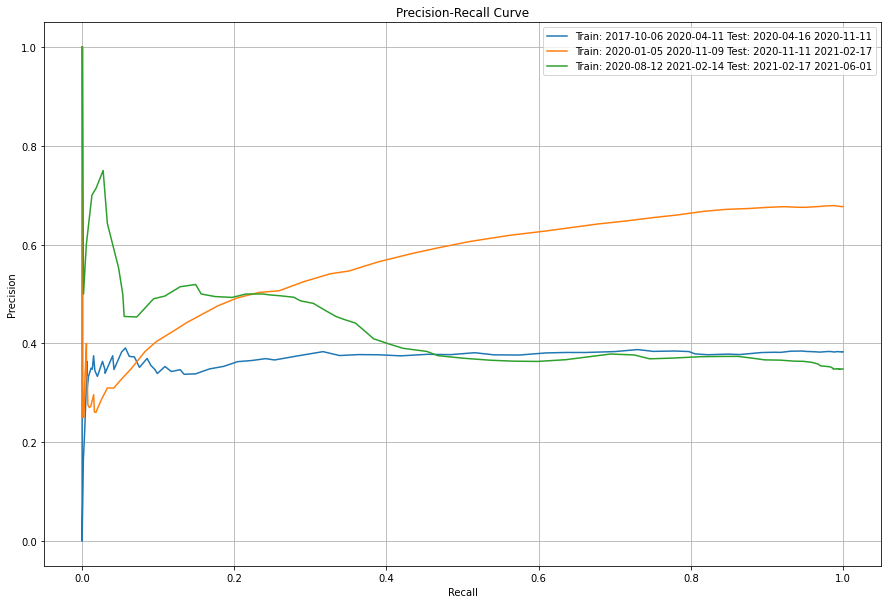

In [66]:
model.plot_precision_recall_curve()

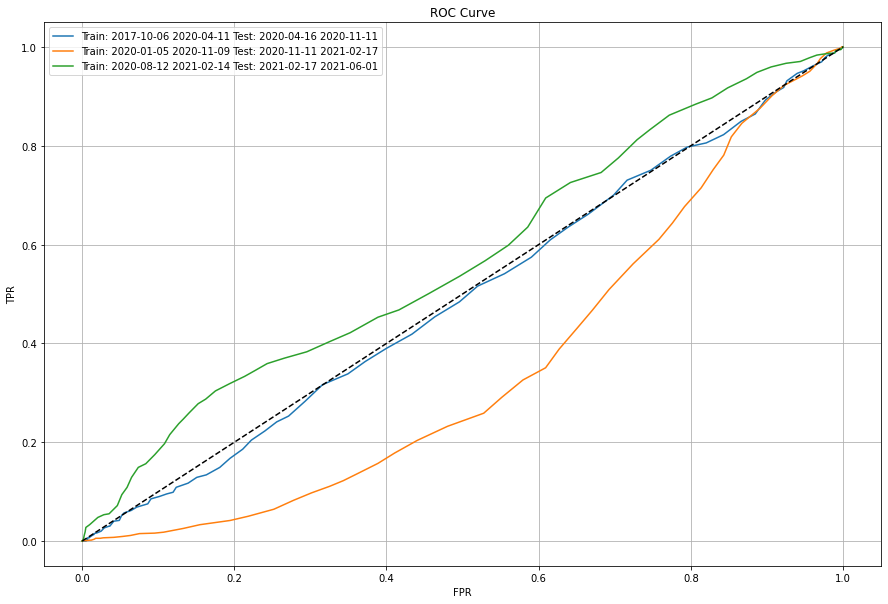

In [67]:
model.plot_roc_curve()

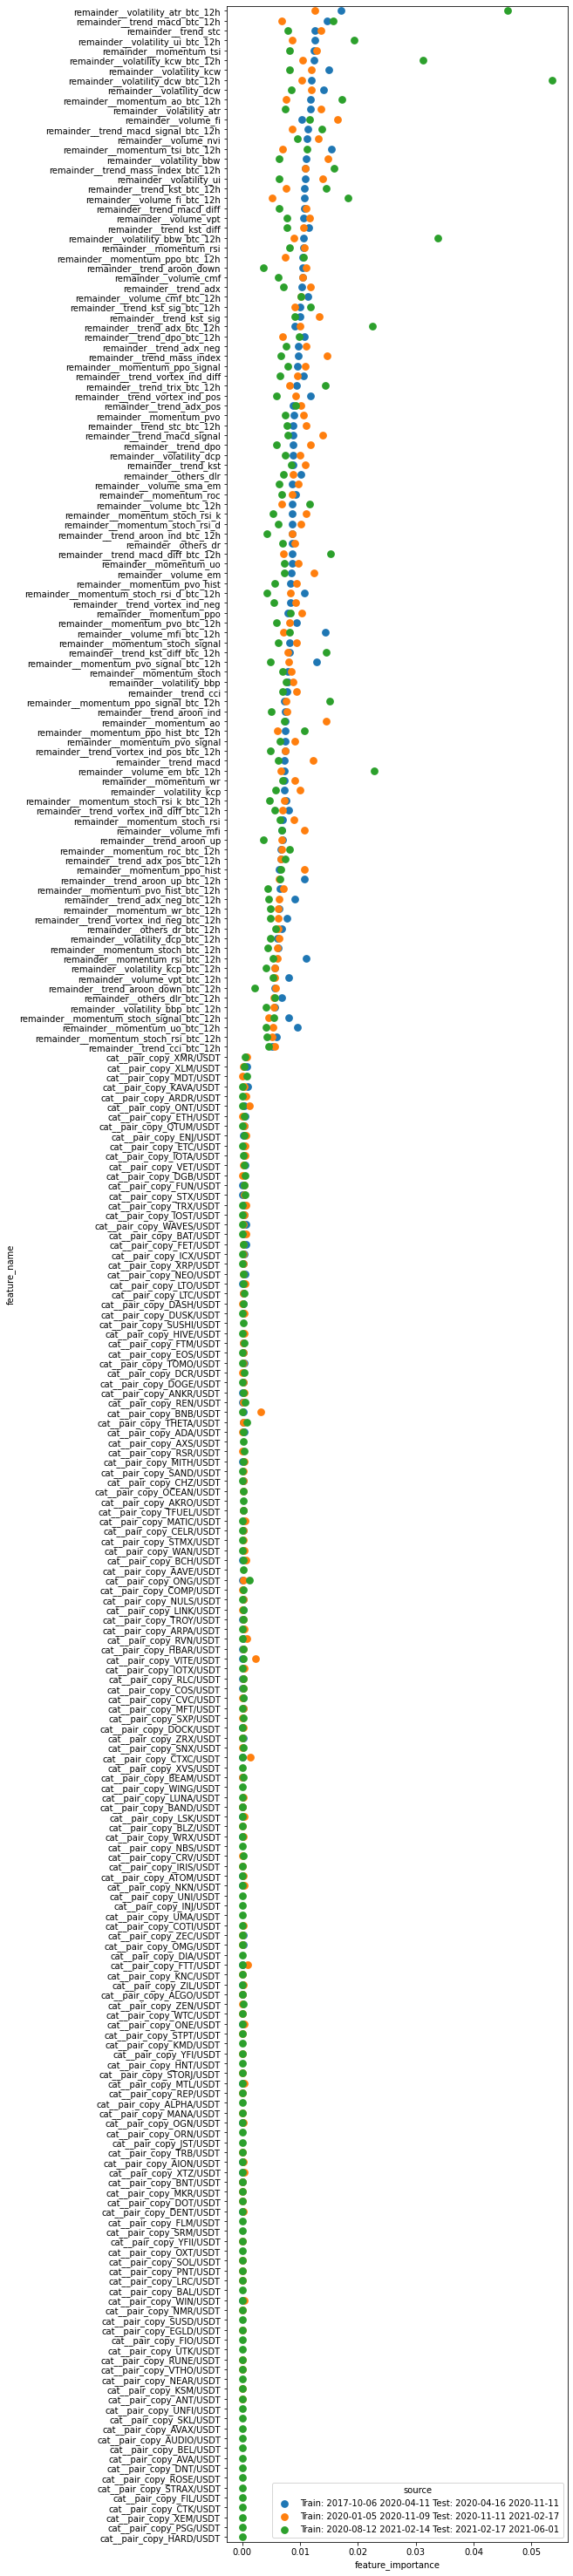

In [68]:
model.plot_feature_importance()

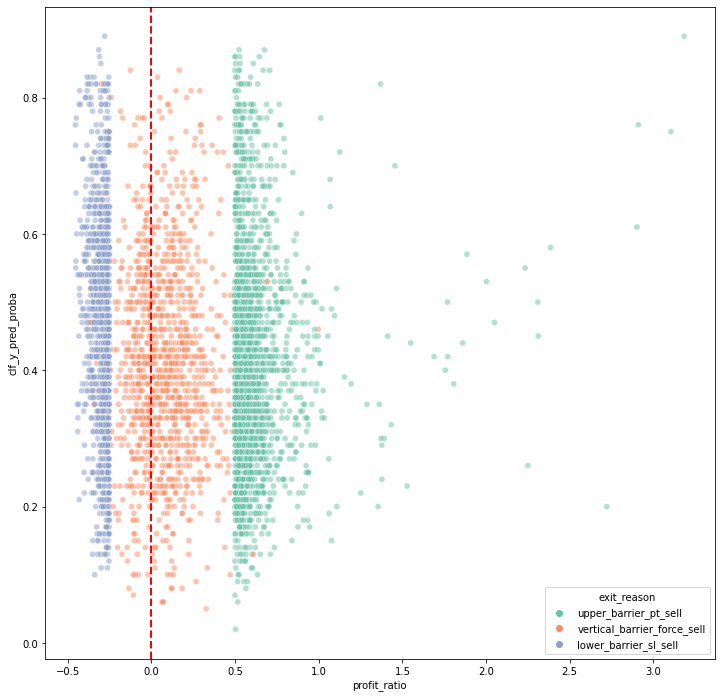

In [69]:
model.plot_probability_returns_scatter()

In [ ]:
model.probability_returns_table()

In [70]:
model.run_train_on_more_data(date_from='2021-01-01')

/Users/mregan/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mregan/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mregan/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mregan/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


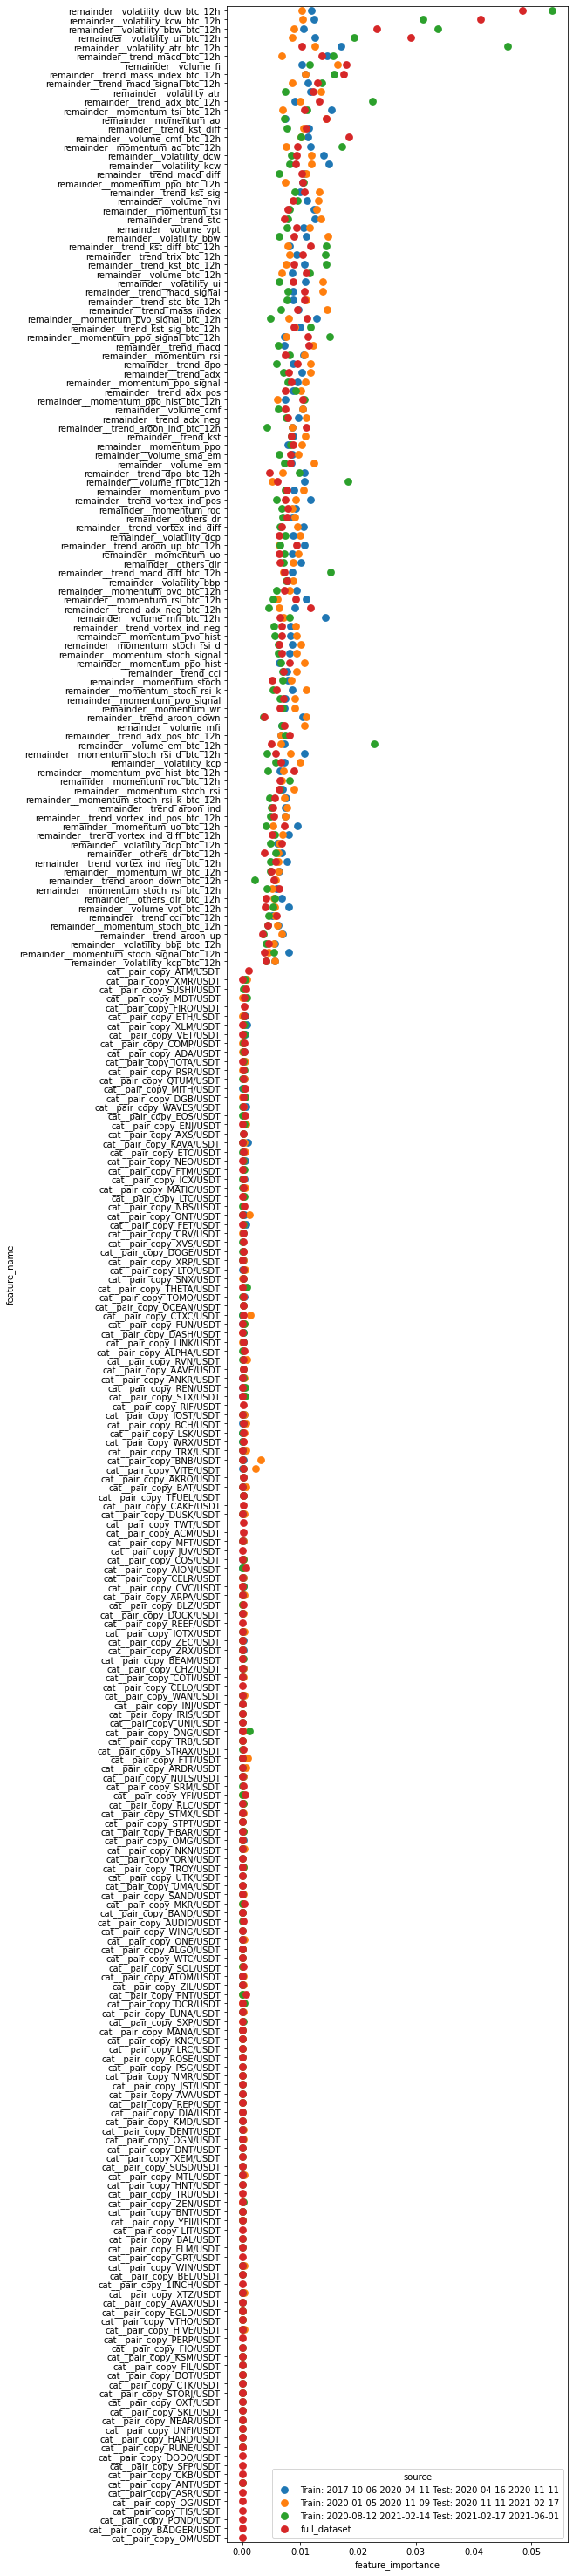

In [71]:
model.plot_feature_importance()

In [ ]:
model.model_threshold_table()

In [73]:
model.set_model_threshold(model_threshold=0.5)

In [74]:
model.save_model(filename='VulcanMeta.pkl')

# Appendix / Testing (to be deleted)

In [ ]:
model.data['clf_y_pred_proba'].hist()

In [ ]:
model.clf.predict_proba(model.data[model.X_features])[:, 1]

In [ ]:
test = model.data.iloc[0:3, :][model.X_features]
test

In [ ]:
nan_test = model.data.iloc[0:3, :][model.X_features].copy()
nan_test[:] = np.nan
nan_test

In [ ]:
model.clf.predict_proba(nan_test)[:, 1]

In [ ]:
some_nan_test = model.data.iloc[0:3, :][model.X_features].copy()
some_nan_test.iloc[:, 3] = np.nan
some_nan_test

In [ ]:
model.clf.predict_proba(some_nan_test)[:, 1]

In [ ]:
ii = mm.InfinityImputer()

In [ ]:
ii.transform(some_nan_test)

In [ ]:
np.nan_to_num(some_nan_test, copy=False)

In [ ]:
some_nan_test.fillna(999)

In [ ]:
np.where(pd.isna(nan_test), 999, some_nan_test)

In [ ]:
np.isinf(nan_test)

In [ ]:
df.loc[:, k_best_features_and_external].to_csv('buy_trades_vulcan with_k_best_signals.csv')

In [ ]:
df.to_csv('all_long_trades_vulcan.csv')

In [ ]:
df.groupby('open_date').size().plot()

In [ ]:
df.groupby('open_date')['pair_copy'].nunique().plot()

In [ ]:
df.loc[idx[:, :, '2019-01-01':'2021-06-01']]

In [ ]:
model.X_train_balanced

In [ ]:
from fracdiff.sklearn import FracdiffStat

In [ ]:
f = FracdiffStat()
X = f.fit_transform(model.X_train_balanced[['trend_kst_diff_ark_1d', 'volatility_kcw_ark_1d', 'volatility_kch']])

In [ ]:
X.shape

In [ ]:
model.X_train_balanced[['trend_kst_diff_ark_1d', 'volatility_kcw_ark_1d', 'volatility_kch']].values.shape

In [ ]:
model.fracdiff_transformer.d_

In [ ]:
model.data